# Part 4: annotating ClusTCR clusters with TCRex

In [1]:
%cd ..

/home/vincent/Documents/projects/tcr_workshop_2023


## Reading in the data

In this part, we will compile the results of the three previous sections. Once again, we will use the `pandas` library for general data handling and integrating following data:

- `repertoires`, the repertoire sequence data after the preprocessing steps described in Part 1 
- `clustering_result`, the result dataframe of ClusTCR clustering, from Part 2
- `tcrex_result_merged`, the merged output from TCRex, processed as in Part 3 

Specifically, after reading in these data separately, we will use pandas' `merge` function to integrate them into one dataframe (table).

In [2]:
import pandas as pd

### a. read in the parsed repertoires:

In [3]:
# Read in the data for sample P1_0 and P1_15
p1_d0 = pd.read_csv('data/P1_0_parsed.tsv', sep='\t', index_col=[0])
p1_d15 = pd.read_csv('data/P1_15_parsed.tsv', sep='\t', index_col=[0])

# Set a timepoint variable to differentiate between both samples
p1_d0["file"] = "P1_0_parsed"
p1_d15["file"] = "P1_15_parsed"

# Concatenate the dataframes for both timepoints
data_merged = pd.concat([p1_d0, p1_d15])

In [4]:
# Read in the clustering result from Part 2
clustering_result = pd.read_csv("data/clustcr_results/clustcr_results.tsv", sep='\t', index_col=[0], dtype={"cluster":str})

# Read in the processed TCRex predictions from Part 3
tcrex_result_merged = pd.read_csv("data/tcrex_result_merged.tsv", sep="\t", index_col=[0])

### b. merge the three tables into one:

In [5]:
# Add clustcr clustering information
data_merged = pd.merge(
    left=data_merged, 
    right=clustering_result.add_prefix("clustcr_"), 
    left_on="junction_aa", 
    right_on="clustcr_junction_aa", 
    how="left"
)

In [6]:
# Preview the first 10 lines of the result

data_merged.head(10)

,junction_aa,v_call,j_call,Total_count,Total_frequency,productive,file,clustcr_junction_aa,clustcr_cluster,clustcr_basicity,clustcr_hydrophobicity,clustcr_helicity,clustcr_mutation stability
0,CASSNSDRTYGDNEQFF,TRBV6-2,TRBJ2-1,33422.0,0.021714,True,P1_0_parsed,NaN,NaN,NaN,NaN,NaN,NaN
1,CATSSVLTQQETQYF,TRBV24-1,TRBJ2-5,24502.0,0.015918,True,P1_0_parsed,NaN,NaN,NaN,NaN,NaN,NaN
2,CASSSRGLANTQYF,TRBV12-3,TRBJ2-3,22361.0,0.014527,True,P1_0_parsed,NaN,NaN,NaN,NaN,NaN,NaN
3,CSVVGADTYEQYF,TRBV29-1,TRBJ2-7,20930.0,0.013598,True,P1_0_parsed,CSVVGADTYEQYF,3986,209.900000,0.285385,1.076154,21.076923
4,CASSLGTALNTEAFF,TRBV7-8,TRBJ1-1,20193.0,0.013119,True,P1_0_parsed,CASSLGTALNTEAFF,4797,209.233333,0.402667,1.114000,20.666667
5,CASSRRHLGNTGELFF,TRBV7-2,TRBJ2-2,18597.0,0.012082,True,P1_0_parsed,NaN,NaN,NaN,NaN,NaN,NaN
6,CASSEGRSNQPQHF,TRBV2,TRBJ1-5,17398.0,0.011303,True,P1_0_parsed,CASSEGRSNQPQHF,3496,213.007143,-1.952143,0.974286,17.428571
7,CASSPSTDTQYF,TRBV27,TRBJ2-3,15607.0,0.010140,True,P1_0_parsed,CASSPSTDTQYF,4466,210.100000,-0.935000,1.000000,18.416667
8,CSAKGQRGGGYEQYF,TRBV20-1,TRBJ2-7,12386.0,0.008047,True,P1_0_parsed,NaN,NaN,NaN,NaN,NaN,NaN
9,CASSQDGAGSVTQYF,TRBV4-1,TRBJ2-5,12114.0,0.007870,True,P1_0_parsed,NaN,NaN,NaN,NaN,NaN,NaN


As you can see, not all TCR sequences are tagged with a cluster. This is to be expected: clusters represent dense groups of neighbouring sequences, and given the sparsity of TCR repertoires not all TCRs are clustered. When no clustering information is available, these fields will be filled with null (NaN) values after merging the two tables.

Next, we will add the TCRex predictions for each clonotype (= combination of V_gene, CDR3 sequence, and J_gene). For this, we will first need to parse the V and J genes, so their format is consistent across the `data_merged` and `tcrex_result` tables. For this, we will apply a function that parses these genes according to the IMGT standard notation, the same function which is also used internally in TCRex. 

In [7]:
# Import the gene parsing function
from src.tools import vj_parsing

# Perform the parsing
data_merged = vj_parsing(data_merged)

# Look at the results
data_merged.head()

,junction_aa,v_call,j_call,Total_count,Total_frequency,productive,file,clustcr_junction_aa,clustcr_cluster,clustcr_basicity,clustcr_hydrophobicity,clustcr_helicity,clustcr_mutation stability,J_family,V_family,J_gene,V_gene
0,CASSNSDRTYGDNEQFF,TRBV6-2,TRBJ2-1,33422.0,0.021714,True,P1_0_parsed,NaN,NaN,NaN,NaN,NaN,NaN,TRBJ02,TRBV06,TRBJ02-01,TRBV06-02
1,CATSSVLTQQETQYF,TRBV24-1,TRBJ2-5,24502.0,0.015918,True,P1_0_parsed,NaN,NaN,NaN,NaN,NaN,NaN,TRBJ02,TRBV24,TRBJ02-05,TRBV24-01
2,CASSSRGLANTQYF,TRBV12-3,TRBJ2-3,22361.0,0.014527,True,P1_0_parsed,NaN,NaN,NaN,NaN,NaN,NaN,TRBJ02,TRBV12,TRBJ02-03,TRBV12-03
3,CSVVGADTYEQYF,TRBV29-1,TRBJ2-7,20930.0,0.013598,True,P1_0_parsed,CSVVGADTYEQYF,3986,209.900000,0.285385,1.076154,21.076923,TRBJ02,TRBV29,TRBJ02-07,TRBV29-01
4,CASSLGTALNTEAFF,TRBV7-8,TRBJ1-1,20193.0,0.013119,True,P1_0_parsed,CASSLGTALNTEAFF,4797,209.233333,0.402667,1.114000,20.666667,TRBJ01,TRBV07,TRBJ01-01,TRBV07-08


The J_family, V_family, J_gene, and V_gene are now succesfully added. The latter two will be used as key columns for merging:

In [8]:
# Add tcrex annotations
data_merged = pd.merge(
    left=data_merged, 
    right=tcrex_result_merged.add_prefix("tcrex_"), 
    left_on=["junction_aa", "V_gene", "J_gene", "file"], 
    right_on =["tcrex_CDR3_beta", "tcrex_TRBV_gene", "tcrex_TRBJ_gene", "tcrex_file"], 
    how="left"
)

In [9]:
# Preview some rows with no missing values (i.e., sequences that are in clusters and have annotations)
data_merged.dropna().head(5)

,junction_aa,v_call,j_call,Total_count,Total_frequency,productive,file,clustcr_junction_aa,clustcr_cluster,clustcr_basicity,...,J_gene,V_gene,tcrex_TRBV_gene,tcrex_CDR3_beta,tcrex_TRBJ_gene,tcrex_epitope,tcrex_pathology,tcrex_score,tcrex_bpr,tcrex_file
21,CASSESSGQETQYF,TRBV25-1,TRBJ2-5,3704.0,0.002406,True,P1_0_parsed,CASSESSGQETQYF,1597,210.157143,...,TRBJ02-05,TRBV25-01,TRBV25-01,CASSESSGQETQYF,TRBJ02-05,FLNRFTTTL,SARS-CoV-2,0.62,0.00003,P1_0_parsed
27,CASSVTDTQYF,TRBV9,TRBJ2-3,2939.0,0.001909,True,P1_0_parsed,CASSVTDTQYF,5609,209.809091,...,TRBJ02-03,TRBV09,TRBV09,CASSVTDTQYF,TRBJ02-03,RQLLFVVEV,SARS-CoV-2,0.98,0.00002,P1_0_parsed
68,CASSLGGNEQFF,TRBV7-3,TRBJ2-1,1187.0,0.000771,True,P1_0_parsed,CASSLGGNEQFF,4462,209.133333,...,TRBJ02-01,TRBV07-03,TRBV07-03,CASSLGGNEQFF,TRBJ02-01,ILHCANFNV,SARS-CoV-2,0.73,0.00008,P1_0_parsed
69,CASSLGGNEQFF,TRBV7-3,TRBJ2-1,1187.0,0.000771,True,P1_0_parsed,CASSLGGNEQFF,4462,209.133333,...,TRBJ02-01,TRBV07-03,TRBV07-03,CASSLGGNEQFF,TRBJ02-01,YLDAYNMMI,SARS-CoV-2,0.69,0.00005,P1_0_parsed
74,CASSLTSNEQFF,TRBV13,TRBJ2-1,1133.0,0.000736,True,P1_0_parsed,CASSLTSNEQFF,4462,210.291667,...,TRBJ02-01,TRBV13,TRBV13,CASSLTSNEQFF,TRBJ02-01,FLPRVFSAV,SARS-CoV-2,0.79,0.00005,P1_0_parsed


# Exploring annotated clusters

For this example we will perform a quick exploration of the merged dataset.  We will briefly look at the changes in the size of YFV-specific clusters, comparing them at the two different timepoints.

In [127]:
# Preview the available pathology annotations
data_merged["tcrex_pathology"].value_counts()

tcrex_pathology
SARS-CoV-2          3396
CMV                 2601
HIV                 1988
Melanoma            1966
EBV                  267
DENV1                181
HCV                  140
Influenza            115
VZV                   97
DENV3/4               40
HTLV1                 34
Multiple Myeloma      33
DENV2                 31
YellowFeverVirus      25
HSV2                  20
Name: count, dtype: int64

The following function filters for TCR clusters where at least one sequence is reactive to an epitope associated with a certain pathology. We will compare the size of these clusters at the two timepoints available. This cluster size can be defined several ways, e.g. the number of unique sequences (breadth), or the fraction of the sequencing reads (depth).

In [128]:
from collections import Counter

def filter_pathology(data:pd.DataFrame, pathology:str) -> pd.DataFrame:
    # Find cluster ids of clusters with at least one annotation
    pathology_clusters = set(data_merged.query("tcrex_pathology == @pathology")["clustcr_cluster"].dropna().to_list())

    # Group by cluster
    df_grouped = (
        data
        .query("clustcr_cluster in @pathology_clusters")
        .groupby(["clustcr_cluster", "file"])
        .agg({"tcrex_epitope":Counter, "tcrex_pathology":Counter, "Total_frequency":sum, "junction_aa":len})
        .reset_index()
    )

    # Rename columns
    df_grouped = df_grouped.rename({"Total_frequency":"sum_frequency", "junction_aa":"num_sequences"}, axis="columns")

    return df_grouped

In [139]:
# An example of the output of this function
filter_pathology(data_merged, "YellowFeverVirus")

,clustcr_cluster,file,tcrex_epitope,tcrex_pathology,sum_frequency,num_sequences
0,0,P1_0_parsed,"{'VTEHDTLLY': 2, nan: 114, 'FLPRVFSAV': 3, 'TL...","{'CMV': 23, nan: 114, 'SARS-CoV-2': 43, 'Melan...",0.001726,214
1,0,P1_15_parsed,"{nan: 111, 'SEISMDNSPNL': 2, 'GLCTLVAML': 1, '...","{nan: 111, 'SARS-CoV-2': 31, 'EBV': 1, 'CMV': ...",0.002640,177
2,1594,P1_0_parsed,"{nan: 48, 'KTSVDCTMYI': 1, 'NLNESLIDL': 2, 'LE...","{nan: 48, 'SARS-CoV-2': 5, 'CMV': 3, 'Melanoma...",0.000381,59
3,1594,P1_15_parsed,"{'NLNESLIDL': 3, nan: 34, 'NLVPMVATV': 2, 'ELA...","{'SARS-CoV-2': 4, nan: 34, 'CMV': 2, 'Melanoma...",0.001215,41
4,1635,P1_0_parsed,{nan: 2},{nan: 2},0.000099,2
5,1635,P1_15_parsed,"{'LLWNGPMAV': 3, nan: 4}","{'YellowFeverVirus': 3, nan: 4}",0.000328,7
6,1969,P1_0_parsed,"{nan: 76, 'NLVPMVATV': 8, 'VTEHDTLLY': 1, 'ELA...","{nan: 76, 'CMV': 9, 'Melanoma': 2, 'HIV': 5, '...",0.000957,100
7,1969,P1_15_parsed,"{nan: 85, 'LLWNGPMAV': 2, 'NLVPMVATV': 3, 'YLN...","{nan: 85, 'YellowFeverVirus': 2, 'CMV': 3, 'SA...",0.002116,101
8,20,P1_0_parsed,"{nan: 44, 'EILDITPCSF': 4, 'FLPRVFSAV': 1, 'TL...","{nan: 44, 'SARS-CoV-2': 11, 'Melanoma': 3, 'Ye...",0.000750,59
9,20,P1_15_parsed,"{nan: 40, 'AMFWSVPTV': 1, 'TLIGDCATV': 4, 'FLN...","{nan: 40, 'Melanoma': 3, 'SARS-CoV-2': 11, 'CM...",0.000913,56


In [135]:
P1_0_size = len(data_merged.query("file=='P1_0_parsed'")["junction_aa"].unique())
P1_15_size = len(data_merged.query("file=='P1_15_parsed'")["junction_aa"].unique())

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

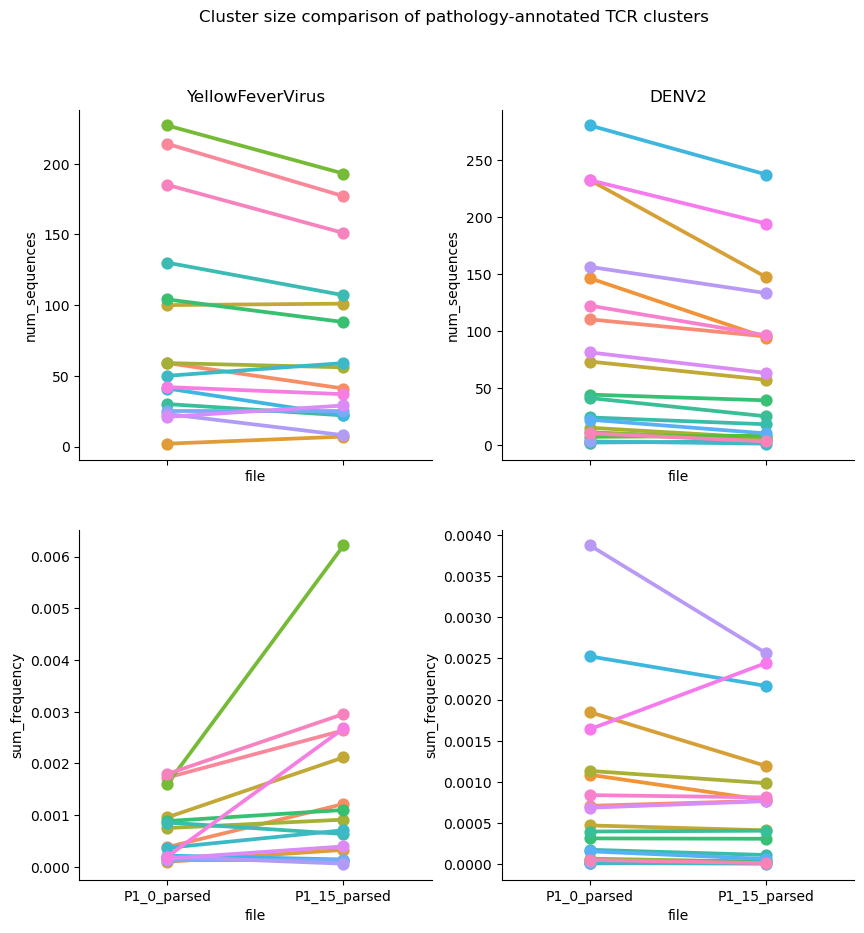

In [125]:
fig, axs = plt.subplots(figsize=(10,10), ncols=2, nrows=2, sharex=True, sharey=False)


for i, pathology in enumerate(["YellowFeverVirus", "DENV2"]):
    df = filter_pathology(data_merged, pathology)
    sns.pointplot(data=df, x="file", y="num_sequences", hue="clustcr_cluster", dodge=False, ax=axs[0][i])
    sns.pointplot(data=df, x="file", y="sum_frequency", hue="clustcr_cluster", dodge=False, ax=axs[1][i])

    axs[0][i].set_title(pathology)

for ax in axs.flatten():
    ax.get_legend().remove()

plt.suptitle(f"Cluster size comparison of pathology-annotated TCR clusters")

sns.despine()